## Challenge: Using Satellite Imagery to Predict Food supply

This document shows the relationship between satellite images and crop production in answer to the challenge project *Using Satellite Imagery to Predict Food supply* [[reference here](https://www.coursera.org/learn/data-science-community/discussions/forums/JaCE3ei1EeafQwrNuRj40A/threads/JHYAj25YEeeCVwouuYV0eA)]. The study was focused on Spain (author's home country).

### Abstract

Is there a correlation between *greenness* and crop yield? Can it be found using downloadable data from [NOAA](https://www.star.nesdis.noaa.gov/smcd/emb/vci/VH/vh_browseByCountry.php) and [FAO](http://www.fao.org/faostat/en)? Indeed there is, at least to some degree: it varies from crop to crop, with a correlation ranging from non-existent to 0.75. It also depends on the time interval under study: some crops seem to be highly conditioned by previous year's greenness, specially vegetables, and other and more directly affected by the year they are harvested, as is the case with cereals.

### 1. Introduction

The objective of the challenge is to identify any relationship, if any exists, between the satellite images that show the evolution of vegetation across the globe and the yield, production or prices of crops. The task is left quite open-ended, so some additional requirements were considered to guide the study:
- The study would focus on Spain.
- The outcome should be something usable and *workable*, i.e., producers could leverage it to improve their harvest.

Note that the second requirement forces the direction of the relationship to be from satellite images to crop production. The opposite direction may exists as well, but will not be considered. Moreover, the imagery should be available *at least some time in advance* so any action can be taken. For example, a small producer may adjust the amount of fertilizer in spring if some numbers are available before that, but not later.

Two datasets were used: 
- Normalized Difference Vegetation Index (NDVI) at 4 km resolution, from NOAA: this satellite measurement, also referred to as *greenness index*, is an indicator of whether live, green vegetation exists in a given area. It is a ratio in the range [-1,1], and as a ratio it does not have units. It is provided as weekly averaged raster files - i.e., each pixel represents the average NDVI in a 4x4 km square during a 7-day period. Maps can be consulted per country with a web form or downloaded as world wide files.
- FAO statistics: the UN organization publishes a wide variety of statistics about food production and many agriculture-related indicators. Crop production and crop yield are the ones under study. Data can be consulted live on the web or downloaded as CSV.

The NOAA dataset spans from 1981 until the present day, whereas FAO has released data from 1961 until 2014. Only overlapping years can be taken into account. Satellite data from 1981 will be discarded because it is incomplete and FAO statistics will be considered starting on 1983 because it is the first year for which previous' year average NVDI can be used.

### 2. Greenness data

The first step was to retrieve NDVI files from NOAA. Although country specific maps can be viewed directly on the web site, this involves a manual process or the use of a web-crawling script. Although doable, if another country's records are required at a later date, the same process would be needed again. Alternatively, all files were downloaded from [NOAA's FTP server](ftp://ftp.star.nesdis.noaa.gov/pub/corp/scsb/wguo/data/VHP_4km/geo_TIFF/). The file naming convention is explained in the [user guide](https://www.star.nesdis.noaa.gov/smcd/emb/vci/VH/vh_documentation.php). NDVI files have a suffix of **SM.SMN**, 4 KM resolution files have the G04 label and weekly averages have the C07 label. More generally, these are the components of a filename with format `VHP.Grr.Ccc.xx.Pyyyywww.pp.nc`:
- `rr`: resolution in km
- `cc`: number of days per composite period
- `xx`: satellite ID
- `yyyy`: year
- `www`: week number
- `pp`: product (SM for averaged NDVI)

All of them were downloaded with a FTP client - 1814 files at the time of writing. A sample file was previewed as follows.

In [1]:
import numpy as np
from scipy import misc
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

TIFF_NA_VALUE_SOURCE = -9999.0
TIFF_NA_VALUE_QGIS   =  -999.0

NVDI_INTERMEDIATE_FILE = 'NVDI-Spain-avg.csv'
FAO_STATS_FILE = 'FAOSTAT_Sp_YieldProd_AllY.csv'

In [2]:
photo_data = misc.imread('VHP.G04.C07.NJ.P2000001.SM.SMN.tif')
minv = photo_data[photo_data != TIFF_NA_VALUE_SOURCE].min()
maxv = photo_data[photo_data != TIFF_NA_VALUE_SOURCE].max()
print('min:\t', minv)
print('max:\t', maxv)
print('height:\t', photo_data.shape[0])
print('width:\t', photo_data.shape[1])
print('pixels:\t', photo_data.size)
print('NA:\t', sum(sum(photo_data == TIFF_NA_VALUE_SOURCE)))

min:	 -0.095
max:	 0.908
height:	 3616
width:	 10000
pixels:	 36160000
NA:	 26689974


The greenness is expressed as a real value, mostly between 0 and 1 but with negative values as well. The user guide notes that points without values (usually water surfaces) are assigned a -9999.0 value. Those points should not be taken into account in any calculation.
The sample image was scaled in the (0,255) and NA values were assigned 0 to glimpse the data.

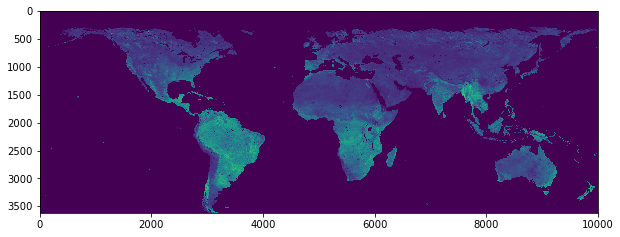

In [3]:
photo_data[photo_data != TIFF_NA_VALUE_SOURCE] = photo_data[photo_data != TIFF_NA_VALUE_SOURCE] + (-minv)
photo_data[photo_data != TIFF_NA_VALUE_SOURCE] = photo_data[photo_data != TIFF_NA_VALUE_SOURCE] * 255 / (maxv - minv)
photo_data[photo_data == TIFF_NA_VALUE_SOURCE] = 0.0
plt.figure(figsize=(10,10))
plt.imshow(photo_data);

The next step was the selection of the area restricted to Spain. This could have been coarsely done by selecting a square in the image (the user guide includes limits in latitude/longitude that can be used to transform between pixels and coordinates). However, GeoTIFF files can be processed efficiently as raster layers with a qGIS, an open-source GIS software.

First, a vector layer with country borders was downloaded from [thematicmapping.org](http://thematicmapping.org/downloads/world_borders.php). Once loaded in qGIS, the feature of Spain was selected. This object is a polygon that was then used to filter the raster layers. Since they are in GeoTIFF, no additional processing is needed because coordinates limits and reference system are all embedded in each file's metadata. The algorithm *Clip raster with polygon* was run in batch mode over all files, saving each output with a *clipped-* preffix.

![](img/qGIS-clip-as-batch.PNG)

These files have valid values only for those points within the Spanish borders. Every other point is NA. Note that the archipelagos are included but Portugal, southern France and northern Africa are not.

-0.028 0.498


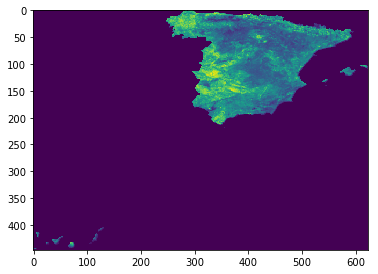

In [4]:
spain =  misc.imread('NOAA-SMN/clipped-VHP.G04.C07.NJ.P2000001.SM.SMN.tif')
spMin = spain[spain >= TIFF_NA_VALUE_QGIS].min()
spMax = spain[spain  >= TIFF_NA_VALUE_QGIS].max()
print(spMin, spMax)
spain[spain  >= TIFF_NA_VALUE_QGIS] = spain[spain  >= TIFF_NA_VALUE_QGIS] + (-spMin)
spain[spain  >= TIFF_NA_VALUE_QGIS] = spain[spain  >= TIFF_NA_VALUE_QGIS] * 255 / (spMax - spMin)
spain[spain  <= TIFF_NA_VALUE_QGIS] = 0.0
plt.figure(figsize=(6,6))
plt.imshow(spain);

The next step was processing all clipped images into values that could be worked on alongside statistical crop data. As a first approach, all valid values within each file were averaged and a single numeric value could be assigned. The year and month were extracted parsing file names. Month numbers were roughly interpolated by dividing the week number by 4.5. The resulting value ranges from 0 to 11. This intermediate values were saved to avoid recomputing of all files.

In [5]:
from os import listdir
from os.path import isfile, join
path = './NOAA-SMN/'
files = [f for f in listdir(path) if (isfile(join(path, f)) and f[0:8] == 'clipped-' and f[-3:] == 'tif')]
print("Files to process: ",str(len(files)))
dataList = []
for f in files:
    y = int(f[24:28]) # naming convention: yyyy is the year
    w = int(f[28:31]) # naming convention: www is the week number
    im =  misc.imread(join(path, f))
    avg = im[im  > TIFF_NA_VALUE_QGIS].mean()  # skip NA values from the average
    dataList.append({'y': y, 'w': w, 'avg': avg})
print("Resulting records: ", str(len(dataList)))
nvdiAvg = pd.DataFrame(dataList)
nvdiAvg['m'] = (nvdiAvg['w'] / 4.5).astype(int)
nvdiAvg['avg'].describe()

Files to process:  1796
Resulting records:  1796


count    1796.000000
mean        0.271776
std         0.042321
min         0.136109
25%         0.245942
50%         0.271723
75%         0.303934
max         0.368349
Name: avg, dtype: float64

Although the resulting dataframe has no nulls, there are some missing files from the source server. There is little else that can be done, but since in all cases there are more than 50% of weekly images available and the model will use averages, the values will be considered valid. 

In [6]:
print("NA: ",str(nvdiAvg.isnull().any()))
nvdiYear = nvdiAvg.groupby(by='y', axis=0)
nvdiYear = nvdiYear.count()
nvdiYear[nvdiYear['avg'] < 50]

NA:  avg    False
w      False
y      False
m      False
dtype: bool


,avg,w,m
y,,,
1984,49,49,49
1985,44,44,44
1988,45,45,45
1994,36,36,36
1995,49,49,49
2004,34,34,34
2017,30,30,30


In [7]:
nvdiAvg.to_csv(NVDI_INTERMEDIATE_FILE, index=False)

### 3. Crop data

Data from FAO was downloaded as CSV for local processing rather that using the web features. The filters were defined as:
- Countries: **Spain**
- Elements: **Yield**, **Production Quantity**, **Area Harvested**
- Items Aggregated: **All**
- Years: **All** (1961-2014).

The resulting file had roughly 18000 records with 14 columns.


In [7]:
stats = pd.read_csv(FAO_STATS_FILE)
stats.head(5)

,Domain Code,Domain,Area Code,Area,Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value,Flag,Flag Description
0,QC,Crops,203,Spain,5419,Yield,221,"Almonds, with shell",1961,1961,hg/ha,10020.0,Fc,Calculated data
1,QC,Crops,203,Spain,5419,Yield,221,"Almonds, with shell",1962,1962,hg/ha,6292.0,Fc,Calculated data
2,QC,Crops,203,Spain,5419,Yield,221,"Almonds, with shell",1963,1963,hg/ha,7276.0,Fc,Calculated data
3,QC,Crops,203,Spain,5419,Yield,221,"Almonds, with shell",1964,1964,hg/ha,7005.0,Fc,Calculated data
4,QC,Crops,203,Spain,5419,Yield,221,"Almonds, with shell",1965,1965,hg/ha,7106.0,Fc,Calculated data


In [8]:
print("Area count: ",str(stats['Area'].unique().shape[0]))
print("Indicators: ",str(stats['Element'].unique()))
print("Types of crop: ",str(stats['Item'].unique().shape[0]))
print("Years: ",str(stats['Year'].min()),"-",str(stats['Year'].max()))
print("Records with NA values: ", str(stats['Value'].isnull().sum()))
records1 = stats.shape[0]
stats = stats[(~ stats['Value'].isnull())]
records2 = stats.shape[0]
print("Dropped records: ", str(records1-records2))
print("Number of records: ", str(stats.shape[0]))
del stats['Flag']
del stats['Flag Description']
del stats['Year Code']
print("Remaining NA:", str(stats.isnull().any().sum()))

Area count:  1
Indicators:  ['Yield' 'Production']
Types of crop:  122
Years:  1961 - 2014
Records with NA values:  254
Dropped records:  254
Number of records:  11675
Remaining NA: 0


This summary confirms that the downloaded data was within the specified limits. There are many types of crops, plus some aggregated types that cover many crops of a similar kind, such as Cereals, Vegetables or Fruits. As will be seen, results vary widely from crop to crop. In order to analyze the relationship, the study will focus on the subset of the highest producing crops.

In [9]:
statsGroup = stats[stats['Element'] == 'Production'].groupby(by='Item')
avgProductionPerItem = statsGroup['Value'].mean()
avgProductionPerItem = avgProductionPerItem.sort_values(ascending=False)
avgProductionPerItem.head(10)

Item
Cereals,Total                1.654859e+07
Cereals (Rice Milled Eqv)    1.636337e+07
Fruit excl Melons,Total      1.270250e+07
Coarse Grain, Total          1.083079e+07
Vegetables&Melons, Total     9.853327e+06
Vegetables Primary           9.853327e+06
Barley                       6.940727e+06
Sugar beet                   6.307290e+06
Grapes                       5.303497e+06
Wheat                        5.161606e+06
Name: Value, dtype: float64

The aggregates appear in this list - this is expected, as they are the sum of several types of crops. The types *Cereals (Rice Milled Eqv)* and *Vegetables Primary* will not be used because they are already included in *Cereals,Total* and *Vegetables&Melons, Total*, respectively.

The analysis will focus on yield, expressed as production per area. Harvested areas may change each year, as a producer may decide to dedicate a certain field to a different type for a number of different reason. By focusing on yield, these decision do not influence the relationship between greenness and the overall production of a certain crop (greenness or other related indexes may have triggered those decisions and hence imply a relationship, but that will be considered out of scope).

The range of years under consideration will start on 1983. Earlier years will be discarded because there is no greenness data available, and for the purpose of the study, both the data of the current and previous year will be considered (therefore, crop data from 1983 will need satellite data from 1983 and 1982). Greenness data from 1981 will be discarded because only the last months are available, and mostly yearly averages will be used.

In [10]:
cropList = avgProductionPerItem[0:10].index.values # list of top 10 producing crops,
cropList = np.delete(cropList, [1,5]) # removing Cereals (Rice Milled Eqv) and Vegetables Primary
mask = (stats['Element'] == 'Yield') & (stats['Item'].isin(cropList)) & (stats['Year'] >= 1983)
stats = stats[mask].copy(deep = True)

Crops data does not need further processing at this point.

### 4. Model

At this point, data from both sources to be merged. Crop yield will be linked with NDVI averages prior to harvest time. Note that this decision is based on the requirement that the results are usable by producers. Since the scope area, Spain, is in the northern hemisphere, the first crops will be harvested in summer (depending on the type). Therefore, NDVI values later than that will not be considered.

Two attributes (or features) will be added to the statistics matrix:
- the average greenness on the first half of the year,
- the average greenness on the previous year.

Yearly averages are the most simple way to summarize greenness data in a value that can be compared with yearly crop statistics. Not all crops are harvested at the same time, and indeed many of them can be sown and harvested more than once or even in a staggered way, yielding products for a long period. Therefore, this two time intervals are merely a first, straightforward approach that could be refined with deeper domain knowledge.

In [11]:
greenness = pd.read_csv(NVDI_INTERMEDIATE_FILE)
yearly =  greenness.groupby(['y'], as_index=False)
yearly = yearly['avg'].mean()
half = greenness[greenness['m'] < (6)].groupby(['y'], as_index=False)
half = half['avg'].mean()


# function to be passed in 'apply'
# receives a single record (row) as parameter, and returns a row with more columns
# it calculates three new features: average NDVI on the same year as the row, 
# on the first halt of that year and on the previous year

def deriveFeatures(r):
    y = int(r['Year'])
    yHalf = half[half['y'] == y]['avg'].values
    yPrev = yearly[yearly['y'] == (y-1)]['avg'].values
    
    features = {'yHalf': yHalf, 'yPrev': yPrev}
    for k in features.keys():
        val = features[k]
        if val.shape[0] == 0:
            r[k] = np.nan
        else:
            r[k] = val[0]
    return r

statsEx = stats.apply(deriveFeatures, axis=1)
statsEx.dropna(axis=0, inplace=True)
statsEx.head()

,Domain Code,Domain,Area Code,Area,Element Code,Element,Item Code,Item,Year,Unit,Value,yHalf,yPrev
862,QC,Crops,203,Spain,5419,Yield,44,Barley,1983,hg/ha,17837.0,0.257603,0.242419
863,QC,Crops,203,Spain,5419,Yield,44,Barley,1984,hg/ha,26819.0,0.276240,0.235869
864,QC,Crops,203,Spain,5419,Yield,44,Barley,1985,hg/ha,25199.0,0.296404,0.260313
865,QC,Crops,203,Spain,5419,Yield,44,Barley,1986,hg/ha,17121.0,0.257709,0.250977
866,QC,Crops,203,Spain,5419,Yield,44,Barley,1987,hg/ha,22352.0,0.295302,0.248813


In [12]:
corrHalf = list()
corrPrev = list()
for item in cropList:
    mask = statsEx['Item'] == item
    corrPd = statsEx[mask].corr()
    corrHalf.append(corrPd['yHalf']['Value'])
    corrPrev.append(corrPd['yPrev']['Value'])
    

results = list(zip(cropList, corrHalf, corrPrev))
results.sort(key=lambda t: t[1], reverse=True)
bestHalf = results.copy()
results.sort(key=lambda t: t[2], reverse=True)
bestPrev = results.copy()

In [13]:
print("Crops that best correlate with fist half of current year's greenness")
for i in bestHalf[0:5]:
    print(i[0],":", "%.4f" % i[1])

Crops that best correlate with fist half of current year's greenness
Cereals,Total : 0.6697
Coarse Grain, Total : 0.6552
Vegetables&Melons, Total : 0.6418
Wheat : 0.6397
Sugar beet : 0.5884


In [14]:
print("Crops that best correlate with previous year's greenness")
for i in bestPrev[0:5]:
    print(i[0],":", "%.4f" % i[2])

Crops that best correlate with previous year's greenness
Vegetables&Melons, Total : 0.7653
Sugar beet : 0.7437
Fruit excl Melons,Total : 0.7014
Grapes : 0.6242
Coarse Grain, Total : 0.4290


This numbers show high correlation values in some cases (around 0.75 in some cases), but these values vary greatly from crop to crop and must be treated with care. For instance, the greenness averages for the current year lead to high correlations, but this is is hardly usable. Any producer will need a whole year's satellite imagery to predict a yield, but by year's end the crops have already been harvested. Therefore, that attribute will no longer be analyzed.

The analysis of the remaining two attributes may be clearer with the plots below. The first one shows the relation, for **wheat**, between the averaged greenness index during the first half of the year and the yield, in hg/ha, for that year. A regression line is depicted in red; two lines in black show the upper and lower limits of the standard error of predictions.

The second plot shows the same data as it has evolved over the years. Although the scales are different, both lines follow each other very closely.

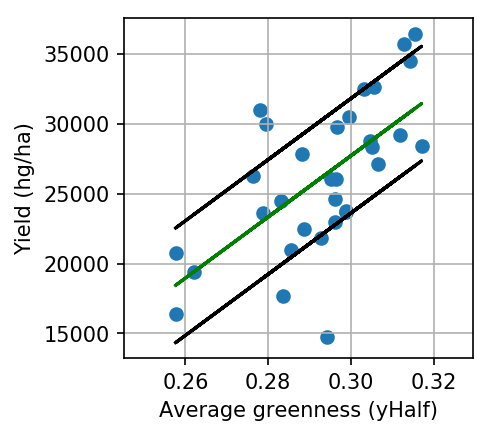

In [15]:
def plotCompareScatter(item, timespan):
    mask = statsEx['Item'] == item
    x = statsEx[mask][timespan].values
    y = statsEx[mask]['Value'].values
    fig, ax0 = plt.subplots(1,1,figsize=(3, 3), dpi=150)
    ax0.scatter(x, y)
    # regression line with least squares polynomial fit of degree 1
    # polyfit returns the coefficients and the sum of residuals
    poly = np.polyfit(x, y, 1, full=True)
    line = np.poly1d(poly[0])
    ax0.plot(x, line(x), 'g')
    # standard error of estimates from sum of residuals
    lineStdErr = np.sqrt(poly[1][0] / x.shape[0])
    ax0.plot(x, line(x) + lineStdErr, 'k')
    ax0.plot(x, line(x) - lineStdErr, 'k')
    
    ax0.set_xlabel('Average greenness (' + timespan + ')')
    ax0.set_ylabel("Yield (hg/ha)")
    ax0.grid(True)
    
plotCompareScatter('Wheat', 'yHalf')

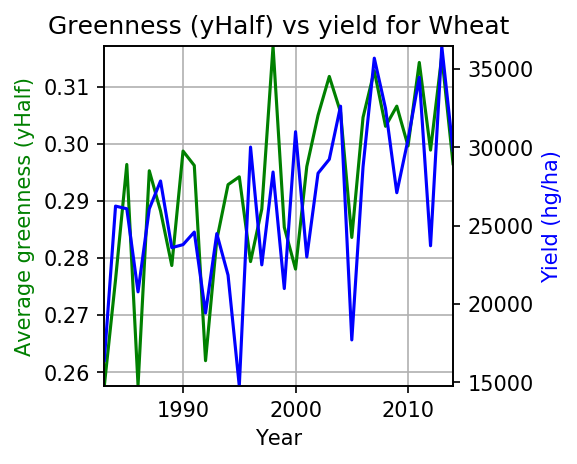

In [16]:
def plotCompareLines(item, timespan):
    mask = statsEx['Item'] == item
    fig, ax0 = plt.subplots(1,1,figsize=(3, 3), dpi=150)
    ax0.plot(statsEx[mask]['Year'].values, statsEx[mask][timespan].values, "g-")
    ax0.set_xlabel('Year')
    ax0.set_ylabel('Average greenness (' + timespan + ')', color = 'g')
    ax0.axis([statsEx[mask]['Year'].values.min(), statsEx[mask]['Year'].values.max(), statsEx[mask]['yHalf'].values.min(), statsEx[mask][timespan].values.max()])
    ax0.grid(True)

    ax1 = ax0.twinx()
    ax1.plot(statsEx[mask]['Year'].values, statsEx[mask]['Value'].values, "b-")
    ax1.set_ylabel("Yield (hg/ha)", color='b')
    ax1.axis([statsEx[mask]['Year'].values.min(), statsEx[mask]['Year'].values.max(), statsEx[mask]['Value'].values.min(), statsEx[mask]['Value'].values.max()])
    ax1.axis()

    ax0.set_title('Greenness (' + timespan + ') vs yield for ' + item, size='large')

    plt.show()
    
plotCompareLines('Wheat', 'yHalf')

Although the relationship seems to be there, it could be argued whether the greenness index is a valuable predictor. After all, wheat is sowed in winter or early spring and harvested in summer, right after the first half of the year has elapsed. A small producer may have little alternative even if he or she is able to get a prediction on how good the year will be. On the other hand, a distributor that usually buys the product in Spain may decide to expand its business channel a bit in advance and buy somewhere else. From a more theoretical point of view, the direction of causality is not clear, as the greenness index may be greatly altered by crops across the country.

On the other hand, crops that are correlated with previous year's averages may be good predictors for a wider group of stakeholders. The following plots replicate the previous ones for sugar beet and the greenness during the previous year.

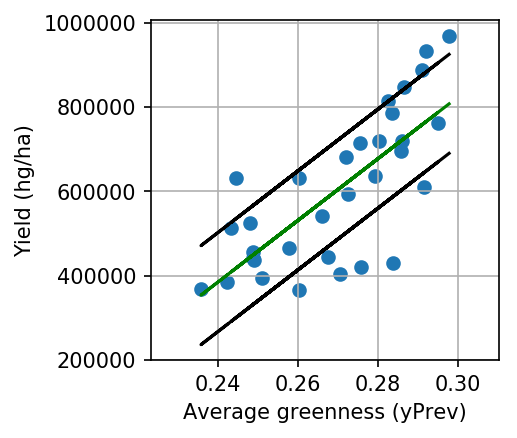

In [17]:
plotCompareScatter('Sugar beet', 'yPrev')

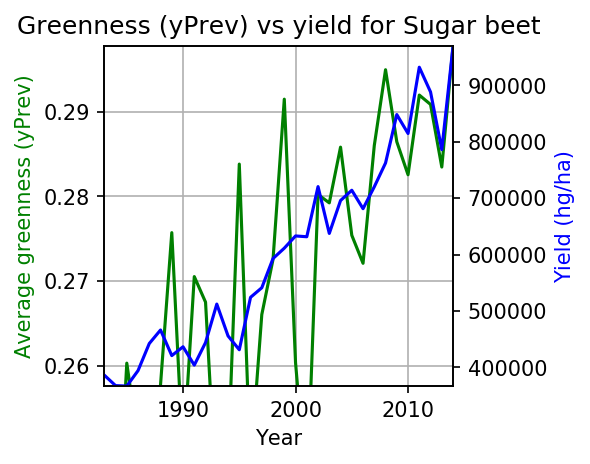

In [18]:
plotCompareLines('Sugar beet', 'yPrev')

In this case, the causality direction is clearer, because the greenness index can be evaluated prior to sowing and harvesting. A small producer with tight margins may decide to switch crops if the numbers promise a low yield, or invest in more fertilizers to ensure that yields do not go down.
The plot also shows a hidden trend: yield has been increasing steadily and regularly over the years. This may be due to other factors such as improvement in fertilizers, better access to water sources or extended use of greenhouses. Again, care must be taken when using predictions based solely on this data.

### 4. Application

Since the target of the study is to find if a relationship exists, the prediction model will be left very simple. In any case, some examples can be run for 2017. The steps below calculate the regression line for what (the same one shown in the plot above) and applies it to the NVDI of the first half of 2017. For comparison, the real value of 2014, the last year with statistics, is also shown.

An error margin, shown as a percentage of the expected value, is derived from the standard error of the prediction. 

In [19]:
mask = statsEx['Item'] == 'Wheat'
x = statsEx[mask]['yHalf'].values
y = statsEx[mask]['Value'].values
poly = np.polyfit(x, y, 1, full=True)
line = np.poly1d(poly[0])
lineStdErr = np.sqrt(poly[1][0] / x.shape[0])

greennessHalf2017 = greenness[(greenness['m'] < (6)) & (greenness['y'] == 2017)  ].groupby(['y'], as_index=False)
greennessHalf2017 = greennessHalf2017['avg'].mean()
greennessHalf2017 = greennessHalf2017['avg'].values[0]
print("NVDI index during first semester of 2017: ", "%.4f" % greennessHalf2017)

expectedWheat2017 = line(greennessHalf2017)
expectedErrorMargin = 100 * lineStdErr / expectedWheat2017
print("Expected wheat yield in 2017 (hg/ha):", "%.0f" % expectedWheat2017, "+/-", "%.0f" % expectedErrorMargin,"%")

wheat2014 = statsEx[(statsEx['Item'] == 'Wheat') & (statsEx['Year'] == 2014)][['Value', 'yHalf']].values[0]
print("Wheat yield in 2014 and NVDI index:", "%.0f" % wheat2014[0], "(hg/ha)", "%.4f" % wheat2014[1] )

NVDI index during first semester of 2017:  0.3171
Expected wheat yield in 2017 (hg/ha): 31460 +/- 13 %
Wheat yield in 2014 and NVDI index: 29806 (hg/ha) 0.2965


Similarly, the same exercise can be applied to the yield of sugar beet. Note that this predicted value could have been calculated back in January 2017, much in advance compared to the previous case.

In [20]:
mask = statsEx['Item'] == 'Sugar beet'
x = statsEx[mask]['yPrev'].values
y = statsEx[mask]['Value'].values
poly = np.polyfit(x, y, 1, full=True)
line = np.poly1d(poly[0])
lineStdErr = np.sqrt(poly[1][0] / x.shape[0])


greenness2016 = greenness[(greenness['y'] == 2016)].groupby(['y'], as_index=False)
greenness2016 = greenness2016['avg'].mean()
greenness2016 = greenness2016['avg'].values[0]
print("NVDI index during first semester of 2017: ", "%.4f" % greenness2016)

expectedBeet2017 = line(greenness2016)
expectedErrorMargin = 100 * lineStdErr / expectedBeet2017
print("Expected sugar beet yield in 2017 (hg/ha):", "%.0f" % expectedBeet2017, "+/-", "%.0f" % expectedErrorMargin,"%")

beet2014 = statsEx[(statsEx['Item'] == 'Sugar beet') & (statsEx['Year'] == 2014)][['Value', 'yPrev']].values[0]
print("Sugar beet yield in 2014 and NVDI index in 2013:", "%.0f" % beet2014[0], "(hg/ha)", "%.4f" % beet2014[1] )

NVDI index during first semester of 2017:  0.2904
Expected sugar beet yield in 2017 (hg/ha): 754027 +/- 16 %
Sugar beet yield in 2014 and NVDI index in 2013: 969258 (hg/ha) 0.2977


### 5. Summary

This study has evaluated the relationship between NDVI as extracted from satellite imagery and crop yields in Spain, with a focus on actionable data for a wide margin of users. Whereas a correlation exists, care must be taken when using this data: not all crops are equally correlated, and the time interval under consideration greatly influences the results.

Additional work could focus on selecting additional time ranges, predicting other values such as fertilizer requirements or extending the model to other countries.